In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Part 1. Optimization

##Logistic Regression

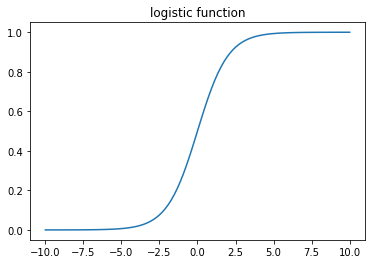

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J


def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad    

In [ ]:
def accuracy(real, predicted):
  true_count = 0
  for i in range(len(real)):
    if real[i]==predicted[i]:
      true_count += 1
  return true_count/len(real)

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0

        self.iter = []
        self.norm = []
        self.cost = []
 
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            self.iter.append(t)
            self.norm.append(np.linalg.norm(g))
            self.cost.append(cost_fn(x, y, self.w))

            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            #print(f'fit: {self.w.shape}')
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def minibatch_fit(self, x, y, batch_size=8):
        # inialize
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            #x['bias'] = np.ones(x.shape[0])
            #self.add_bias = False
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        #t = 0
        # the code snippet below is for mini-batch stochastic gradient descent
        total_sample = N
        if batch_size > total_sample:
          batch_size = total_sample
        num_batch = int(total_sample/batch_size)
        max_iters_batch = self.max_iters/num_batch

        # permutation of index in the range of sample size
        #random_indices = np.random.permutation(total_sample)
        # shuffle them in the same order!!
        x_perm = np.copy(x)
        y_perm = np.copy(y)
        np.random.seed(99) 
        np.random.shuffle(x_perm)
        np.random.seed(99) 
        np.random.shuffle(y_perm)
          
        count = 0
        curr = 0
        self.cost = []
        self.total_iter = 0
        while count < num_batch:
          t = 0
          xi = x_perm[curr:(curr+batch_size)]
          yi = y_perm[curr:(curr+batch_size)]

          while np.linalg.norm(g) > self.epsilon and t < max_iters_batch:
              g = self.gradient(xi, yi)
              self.w = self.w - self.learning_rate * g 
              self.cost.append(cost_fn(xi, yi, self.w))
              t += 1

          curr += batch_size
          count += 1
          #print(t)
          self.total_iter += t

        if self.verbose:
            print(f'terminated all {num_batch} mini-batch(es), with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')

        return self

    def gd_momentum(self, x, y, beta):
      if x.ndim == 1:
        x = x[:, None]
      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      N,D = x.shape
      C = y.shape[0]
      self.w = np.zeros(D)
      dw = 0
      t = 0
      grad = np.inf
      # T = max_T
      self.cost = []
      self.iter = []
      self.norm = []
      train_acc = []
      val_acc = []
      w_history = []
      while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
        #self.cost.append(cost_fn(x, y, self.w))
        self.iter.append(t)
        self.norm.append(np.linalg.norm(grad))
        self.cost.append(cost_fn(x, y, self.w))
        grad = self.gradient(x,y)
        dw = beta * dw + (1-beta) * grad
        self.w = self.w - self.learning_rate * dw
        # if (self.cost[t]<self.cost[t-1]):
        #   T = max_T
        #   bestDW = dw
        #   bestW = self.w
        # else:
        #   T -= 1
        # if T==0:
        #   break
        t+=1
      return self
    def minibatch_momentum(self,x,y,beta,batch_size=8):
      if x.ndim == 1:
            x = x[:, None]
      if self.add_bias:
          N = x.shape[0]
          x = np.column_stack([x,np.ones(N)])
      N,D = x.shape
      self.w = np.zeros(D)
      g = np.inf 
      total_sample = N
      if batch_size > total_sample:
        batch_size = total_sample
      num_batch = int(total_sample/batch_size)
      max_iters_batch = self.max_iters/num_batch

      x_perm = np.copy(x)
      y_perm = np.copy(y)
      np.random.seed(99) 
      np.random.shuffle(x_perm)
      np.random.seed(99) 
      np.random.shuffle(y_perm)
      dw = 0
      count = 0
      curr = 0
      self.cost = []
      self.iter = 0
      while count < num_batch:
        t = 0
        xi = x_perm[curr:(curr+batch_size)]
        yi = y_perm[curr:(curr+batch_size)]

        while np.linalg.norm(g) > self.epsilon and t < max_iters_batch:
            g = self.gradient(xi, yi)
            dw = beta * dw + (1-beta) * g
            self.w = self.w - self.learning_rate * dw 
            self.cost.append(cost_fn(xi, yi, self.w))
            t += 1

        curr += batch_size
        count += 1
        self.iter += t

      if self.verbose:
          print(f'terminated all {num_batch} mini-batch(es), with norm of the gradient equal to {np.linalg.norm(g)}')
          print(f'the weight found: {self.w}')

      return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def predict_outcome(self, x):
        predicted = []
        for prob in self.predict(x):
          if prob>=0.5: predicted.append(1)
          else: predicted.append(0)
        return predicted

    def accuracy(self, x, y):
        true_count = 0
        pred = self.predict_outcome(x)
        for i in range(len(y)):
            if pred[i]==y[i]:
              true_count += 1
        return true_count/len(y)

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

terminated all 1 mini-batch(es), with norm of the gradient equal to 0.04021104531179171
the weight found: [-1.36481704  2.27699195]


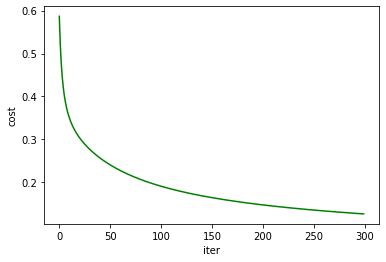

In [ ]:
'''
#example
N = 50
x = np.linspace(-5,5, N)
y = ( x < 2).astype(int)                                  #generate synthetic data
model = LogisticRegression(verbose=True, )
m = model.minibatch_fit(x,y,int(len(x)/2))
yh = m.predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()
'''
#example
N = 50
x = np.linspace(-5,5, N)
y = ( x < 2).astype(int)                                  #generate synthetic data
model = LogisticRegression(max_iters=300, verbose=True, )
m = model.minibatch_fit(x,y,len(x))
'''
yh = m.predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()
'''
iter = range(m.total_iter)
cost = m.cost
plt.plot(iter, cost, 'g')
plt.xlabel('iter')
plt.ylabel('cost')
#plt.legend()
plt.show()

terminated after 300 iterations, with norm of the gradient equal to 0.040211045311791704
the weight found: [-1.36481704  2.27699195]


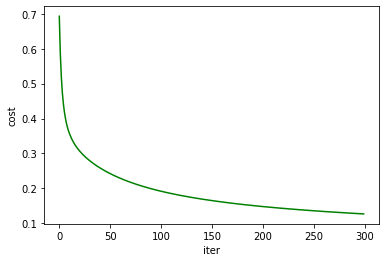

In [ ]:

#example
N = 50
x = np.linspace(-5,5, N)
y = ( x < 2).astype(int)                                  #generate synthetic data
model = LogisticRegression(max_iters=300, verbose=True, )
m = model.fit(x,y)
'''
yh = m.predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()
'''
iter = m.iter
cost = m.cost
plt.plot(iter, cost, 'g')
plt.xlabel('iter')
plt.ylabel('cost')
#plt.legend()
plt.show()

##Load data

In [ ]:
diabetes_train = pd.read_csv('/content/diabetes_train.csv')
diabetes_val = pd.read_csv('/content/diabetes_val.csv')
diabetes_test = pd.read_csv('/content/diabetes_test.csv')
diabetes_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,144,82,26,285,32.0,0.452,58,1
1,0,128,68,19,180,30.5,1.391,25,1
2,9,156,86,28,155,34.3,1.189,42,1
3,1,144,82,46,180,46.1,0.335,46,1
4,0,179,90,27,0,44.1,0.686,23,1
...,...,...,...,...,...,...,...,...,...
595,4,158,78,0,0,32.9,0.803,31,1
596,12,84,72,31,0,29.7,0.297,46,1
597,2,158,90,0,0,31.6,0.805,66,1
598,2,83,66,23,50,32.2,0.497,22,0


In [ ]:
diabetes_train.shape

(600, 9)

In [ ]:
cat = list(diabetes_train.columns[:-1])
print(diabetes_train[cat].shape)
print(diabetes_train['Outcome'].shape)

(600, 8)
(600,)


In [ ]:
diabetes_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               600 non-null    int64  
 1   Glucose                   600 non-null    int64  
 2   BloodPressure             600 non-null    int64  
 3   SkinThickness             600 non-null    int64  
 4   Insulin                   600 non-null    int64  
 5   BMI                       600 non-null    float64
 6   DiabetesPedigreeFunction  600 non-null    float64
 7   Age                       600 non-null    int64  
 8   Outcome                   600 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 42.3 KB


In [ ]:
categories = [var for var in diabetes_train.columns][:-1]

print('There are {} continuous variables\n'.format(len(categories)))

print('The continuous variables are :', categories)

There are 8 continuous variables

The continuous variables are : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [ ]:
x_train, y_train = diabetes_train[categories], diabetes_train['Outcome'] 
x_val, y_val = diabetes_val[categories], diabetes_val['Outcome'] 
x_test, y_test = diabetes_test[categories], diabetes_test['Outcome'] 

In [ ]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,5,144,82,26,285,32.0,0.452,58
1,0,128,68,19,180,30.5,1.391,25
2,9,156,86,28,155,34.3,1.189,42
3,1,144,82,46,180,46.1,0.335,46
4,0,179,90,27,0,44.1,0.686,23
...,...,...,...,...,...,...,...,...
595,4,158,78,0,0,32.9,0.803,31
596,12,84,72,31,0,29.7,0.297,46
597,2,158,90,0,0,31.6,0.805,66
598,2,83,66,23,50,32.2,0.497,22


In [ ]:
x_train.shape

(600, 8)

In [ ]:
x_train.loc[[3,5,1]].shape

(3, 8)

##1.1 Find learning rate and iterations

In [ ]:
#Try
model = LogisticRegression(learning_rate=0.001, max_iters=1000, verbose=True,)
m_try = model.fit(x_train,y_train)

terminated after 1000 iterations, with norm of the gradient equal to 66.45228112905755
the weight found: [ 0.18290047  0.05207662 -0.09314978 -0.02014158  0.0265444  -0.00865251
  0.00519138  0.01690451 -0.03550479]


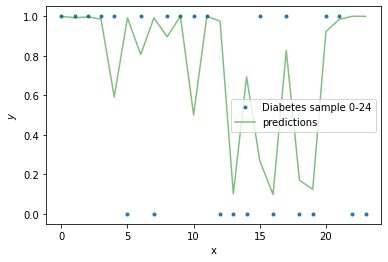

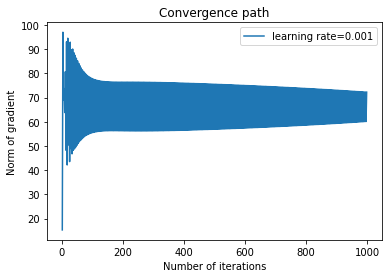

Training accuray is 0.5466666666666666
Validation accuray is 0.49


"\nplt.plot(iter_try, acc_try, label='learning rate=0.001')\nplt.title('Accuracy vs Number of iterations')\nplt.xlabel('Number of iterations')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.show()\n"

In [ ]:

yh = m_try.predict(x_train)

#For the first 24 samples
plt.plot([sample_num for sample_num in range(24)], y_train[:24], '.', label='Diabetes sample 0-24')
plt.plot([sample_num for sample_num in range(24)], yh[:24], 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

#for all. iter vs norm
iter_try = m_try.iter
norm_try = m_try.norm
plt.plot(iter_try, norm_try, label='learning rate=0.001')
plt.title('Convergence path')
plt.xlabel('Number of iterations')
plt.ylabel('Norm of gradient')
plt.legend()
plt.show()

#for all. iter vs acc
iter_try = m_try.iter
predOutcome_try = m_try.predict_outcome(x_train)
acc_try = accuracy(y_train, predOutcome_try)
print("Training accuray is", acc_try)

predOutcome_try_val = m_try.predict_outcome(x_val)
acc_try_val = accuracy(y_val, predOutcome_try_val)
print("Validation accuray is", acc_try_val)


'''
plt.plot(iter_try, acc_try, label='learning rate=0.001')
plt.title('Accuracy vs Number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''

In [ ]:
def LR_convergence(x_train, y_train, x_val, y_val, learning_rate, max_iters):
  train_accuracy = []
  val_accuracy = []

  for it in max_iters:
    model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=it, verbose=False)
    m = model.fit(x_train,y_train) 
    iter = m.iter
    norm = m.norm

    train_accuracy.append(m.accuracy(x_train, y_train))
    val_accuracy.append(m.accuracy(x_val, y_val))

  plt.plot(max_iters, train_accuracy, label = 'training')
  plt.plot(max_iters, val_accuracy, label = 'validation')
  plt.title('Accuracy vs Number of epoch')
  plt.xlabel('Number of epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  return train_accuracy, val_accuracy

In [ ]:
def m_convergence(x_train, y_train, x_val, y_val, learning_rate, max_iters, beta):
  train_acc = []
  val_acc = []

  for it in max_iters:
    model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=it, verbose=False)
    m = model.gd_momentum(x_train, y_train, beta)
    

    train_acc.append(m.accuracy(x_train,y_train))
    val_accuracy.append(m.accuracy(x_val,y_val))

  plt.plot(max_iters, train_accuracy, label = 'training')
  plt.plot(max_iters, val_accuracy, label = 'validation')
  plt.title('Accuracy vs Number of epoch (with momentum)')
  plt.xlabel('Number of epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  return train_acc, val_acc


In [ ]:
max_iters = np.linspace(10,1000,num=100)
m_trial0 = 

### Trials (lr=[0.001, 0.0005, 0.0003, 0.0002])

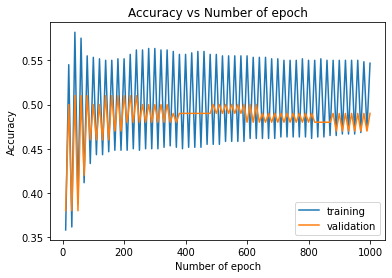

In [ ]:
max_iters = np.linspace(10, 1000, num=100)
trial0= LR_convergence(x_train, y_train, x_val, y_val, 0.001, max_iters)

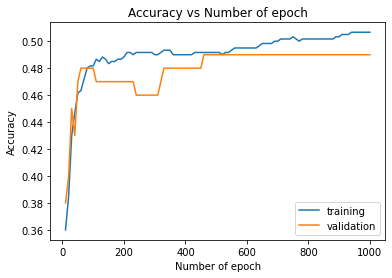

In [ ]:
max_iters = np.linspace(10, 1000, num=100)
trial1= LR_convergence(x_train, y_train, x_val, y_val, 0.0005, max_iters)

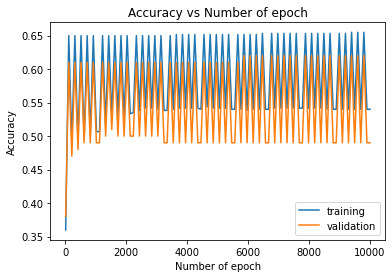

In [ ]:
max_iters = np.linspace(10, 10000, num=100)
trial1= LR_convergence(x_train, y_train, x_val, y_val, 0.0005, max_iters)

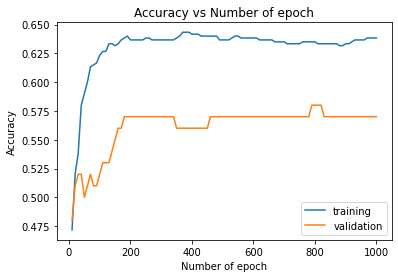

In [ ]:
max_iters = np.linspace(10, 1000, num=100)
trial1= LR_convergence(x_train, y_train, x_val, y_val, 0.0003, max_iters)

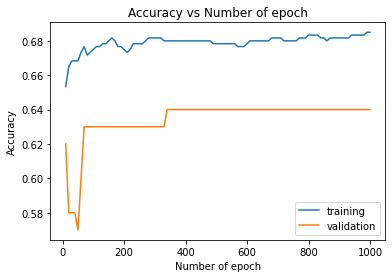

In [ ]:
max_iters = np.linspace(10, 1000, num=100)
trial2= LR_convergence(x_train, y_train, x_val, y_val, 0.0002, max_iters)

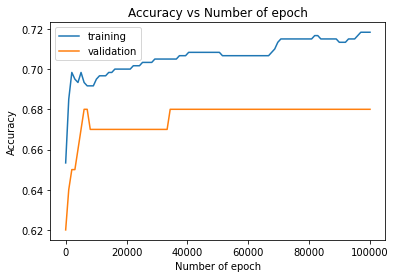

In [ ]:
max_iters = np.linspace(10, 1e5, num=100)
trial1= LR_convergence(x_train, y_train, x_val, y_val, 0.0002, max_iters)

### lr=0.0001

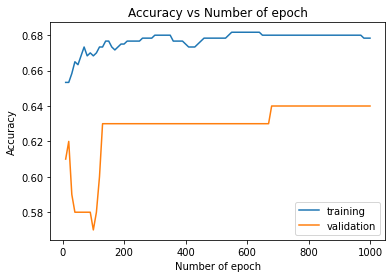

In [ ]:
max_iters = np.linspace(10, 1000, num=100)
trial2= LR_convergence(x_train, y_train, x_val, y_val, 0.0001, max_iters)

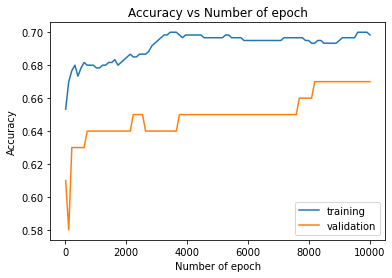

In [ ]:
max_iters = np.linspace(10, 10000, num=100)
trial2= LR_convergence(x_train, y_train, x_val, y_val, 0.0001, max_iters)

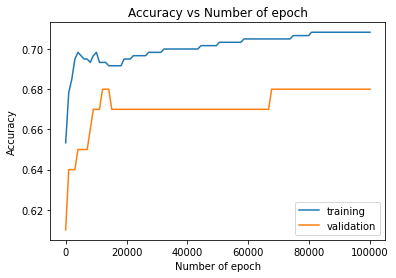

In [ ]:
max_iters = np.linspace(10, 1e5, num=100)
trial2= LR_convergence(x_train, y_train, x_val, y_val, 0.0001, max_iters)

In [ ]:
train_acc_max = max(trial2[0])
val_acc_max = max(trial2[1])
print(train_acc_max)
print(val_acc_max)
trial2[1].index(val_acc_max)

0.7083333333333334
0.68


12

In [ ]:
# number of epoch to reach max val acc
np.linspace(10, 1e5, num=100)[12]

12130.0

In [ ]:
trial2[0][12]

0.6933333333333334

In [ ]:
trial2[1][12]

0.68

###Other

----------------------------max_iters = 5----------------------------
terminated after 5 iterations, with norm of the gradient equal to 3.919319563636594
the weight found: [ 1.01321882e-04 -1.31561886e-03 -4.30721261e-03 -1.01505983e-03
  1.58758755e-03 -1.22435172e-03 -9.03695337e-06 -9.42399693e-04
 -7.16915502e-05]


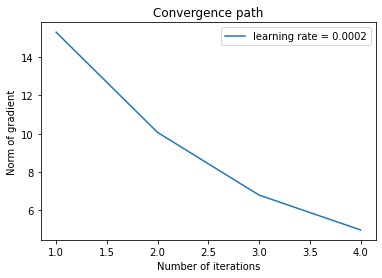

The training accuracy is 0.6533333333333333
The validation accuracy is 0.62
----------------------------max_iters = 10----------------------------
terminated after 10 iterations, with norm of the gradient equal to 2.6761828634633464
the weight found: [ 3.18879718e-04  1.15258347e-04 -6.59386305e-03 -1.61668873e-03
  1.90675396e-03 -1.62036243e-03 -7.41229307e-06 -9.70967787e-04
 -1.17242546e-04]


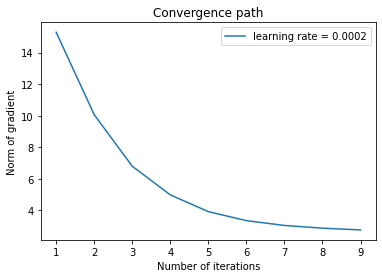

The training accuracy is 0.6533333333333333
The validation accuracy is 0.62
----------------------------max_iters = 50----------------------------
terminated after 50 iterations, with norm of the gradient equal to 1.1139727357715634
the weight found: [ 2.15289901e-03  7.13950783e-03 -1.79250413e-02 -4.09032213e-03
  1.74056953e-03 -3.51488022e-03  1.87488347e-05 -5.23878993e-04
 -4.52678266e-04]


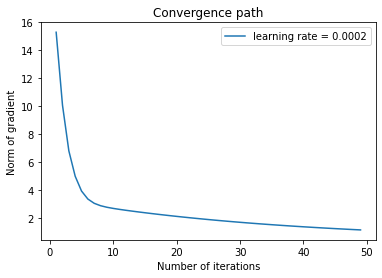

The training accuracy is 0.6683333333333333
The validation accuracy is 0.57
----------------------------max_iters = 100----------------------------
terminated after 100 iterations, with norm of the gradient equal to 0.5071441528159011
the weight found: [ 4.48357763e-03  1.04557640e-02 -2.39198958e-02 -4.46577603e-03
  1.62872466e-03 -4.45694214e-03  6.70064642e-05  5.12640364e-04
 -8.40439102e-04]


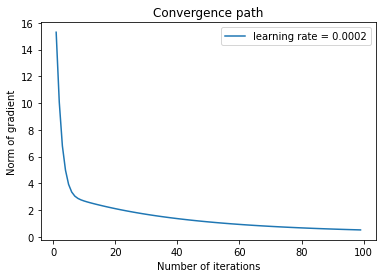

The training accuracy is 0.675
The validation accuracy is 0.63
----------------------------max_iters = 1000----------------------------
terminated after 1000 iterations, with norm of the gradient equal to 0.16017647825706635
the weight found: [ 0.03803532  0.01240471 -0.03059833 -0.00103176  0.00146729 -0.00593856
  0.00107362  0.00283436 -0.00742763]


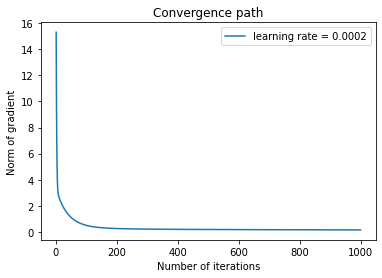

The training accuracy is 0.685
The validation accuracy is 0.64
----------------------------max_iters = 10000----------------------------
terminated after 10000 iterations, with norm of the gradient equal to 0.03688780005515957
the weight found: [ 0.1270723   0.01360155 -0.03072393 -0.00098248  0.00157526 -0.00516212
  0.01310928 -0.01147053 -0.07150879]


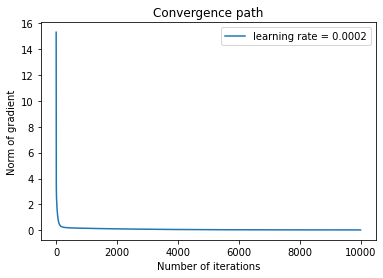

The training accuracy is 0.695
The validation accuracy is 0.67
----------------------------max_iters = 100000----------------------------
terminated after 100000 iterations, with norm of the gradient equal to 0.03248131334125506
the weight found: [ 0.13041944  0.01501208 -0.02859516 -0.00134487  0.00140752  0.0009135
  0.12273586 -0.01057542 -0.67602891]


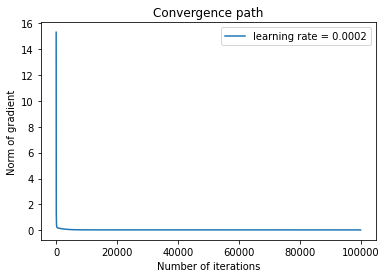

The training accuracy is 0.7183333333333334
The validation accuracy is 0.68


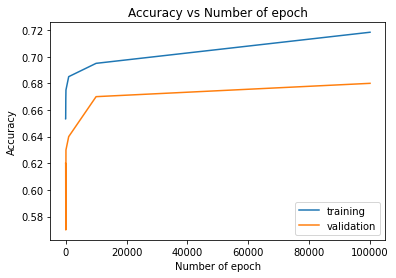

In [ ]:
LR_convergence(x_train, y_train, x_val, y_val, 0.0002, max_iters)

----------------------------max_iters = 5----------------------------
terminated after 5 iterations, with norm of the gradient equal to 36.05069636994092
the weight found: [ 8.30038206e-05 -4.62351371e-03 -7.77529851e-03 -2.07494335e-03
 -1.35865695e-03 -2.47209769e-03 -2.39623741e-05 -2.04302550e-03
 -1.26411845e-04]


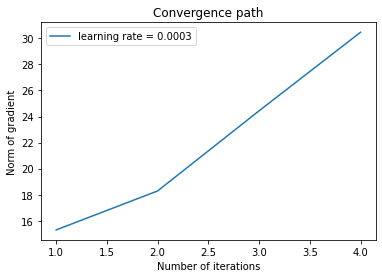

The training accuracy is 0.645
The validation accuracy is 0.65
----------------------------max_iters = 10----------------------------
terminated after 10 iterations, with norm of the gradient equal to 41.829591680901075
the weight found: [ 6.42022063e-04  4.89853544e-03 -6.95410801e-03 -1.64987357e-03
  6.45298647e-03 -1.12235337e-03  8.21468049e-06 -5.69040794e-05
 -1.34630611e-04]


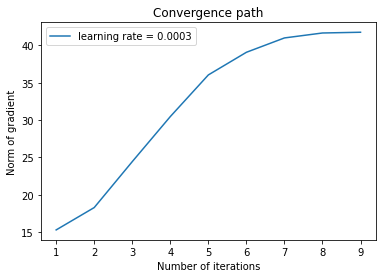

The training accuracy is 0.4716666666666667
The validation accuracy is 0.48
----------------------------max_iters = 50----------------------------
terminated after 50 iterations, with norm of the gradient equal to 36.556270178452195
the weight found: [ 3.42558950e-03  1.33047424e-02 -2.16447460e-02 -5.39691392e-03
  6.08784630e-03 -3.66570595e-03  4.93834523e-05  9.25363915e-04
 -6.26386946e-04]


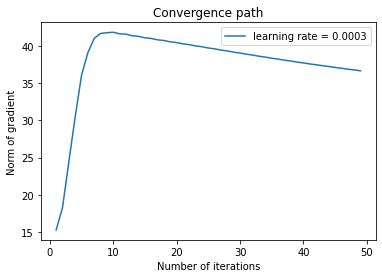

The training accuracy is 0.59
The validation accuracy is 0.5
----------------------------max_iters = 100----------------------------
terminated after 100 iterations, with norm of the gradient equal to 33.28242126589671
the weight found: [ 0.00690003  0.01607514 -0.02765106 -0.00569086  0.00562769 -0.00469092
  0.0001249   0.00259975 -0.00119563]


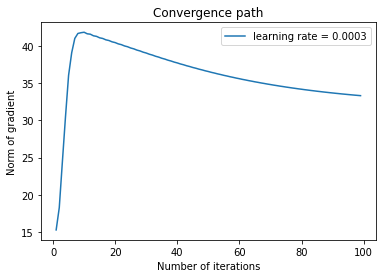

The training accuracy is 0.6233333333333333
The validation accuracy is 0.52
----------------------------max_iters = 1000----------------------------
terminated after 1000 iterations, with norm of the gradient equal to 31.000048945680803
the weight found: [ 0.05395655  0.01671212 -0.03226624 -0.00224119  0.00527484 -0.00629085
  0.00166314  0.00305808 -0.01102824]


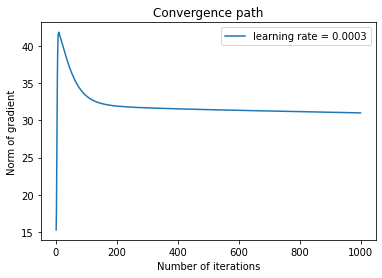

The training accuracy is 0.6383333333333333
The validation accuracy is 0.57
----------------------------max_iters = 10000----------------------------
terminated after 10000 iterations, with norm of the gradient equal to 27.272874947005185
the weight found: [ 0.14544892  0.01738845 -0.03181029 -0.00191222  0.00491936 -0.00514816
  0.02020369 -0.01203238 -0.10655525]


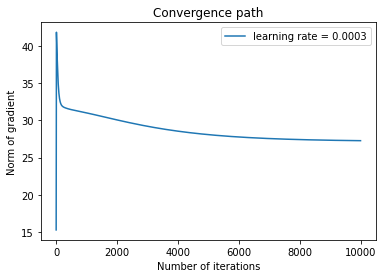

The training accuracy is 0.6383333333333333
The validation accuracy is 0.62
----------------------------max_iters = 100000----------------------------
terminated after 100000 iterations, with norm of the gradient equal to 26.54821225858768
the weight found: [ 0.14349403  0.01933146 -0.02863916 -0.00231442  0.00456354  0.00371991
  0.17805562 -0.00966235 -0.99408758]


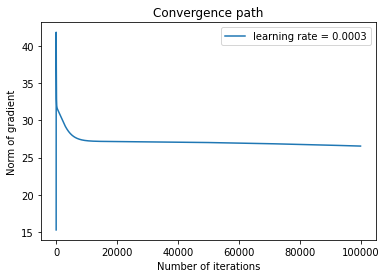

The training accuracy is 0.665
The validation accuracy is 0.63


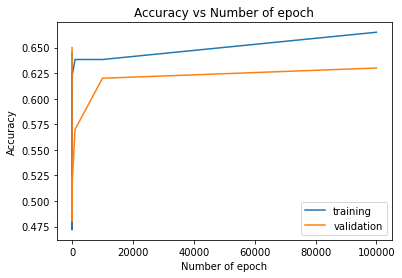

In [ ]:
LR_convergence(x_train, y_train, x_val, y_val, 0.0003, max_iters)

----------------------------Learning rate = 0.0002----------------------------
terminated after 10000 iterations, with norm of the gradient equal to 0.03688780005515957
the weight found: [ 0.1270723   0.01360155 -0.03072393 -0.00098248  0.00157526 -0.00516212
  0.01310928 -0.01147053 -0.07150879]


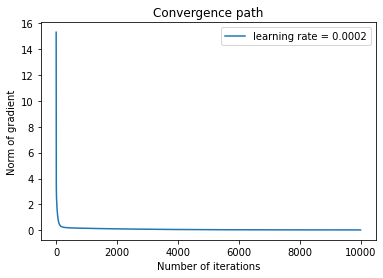

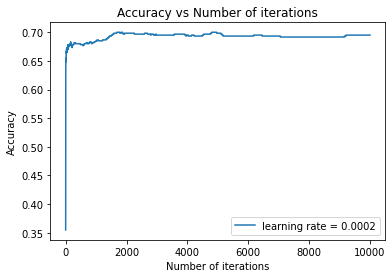

0.7

In [ ]:
trial1_3 = LR_convergence(x_train, y_train, 0.0002, 10000)
max(trial1_3[2])

----------------------------Learning rate = 0.0003----------------------------
terminated after 1000000 iterations, with norm of the gradient equal to 0.008853106134042181
the weight found: [ 1.32522942e-01  2.82949842e-02 -1.65228961e-02 -2.79053981e-03
  1.38709711e-04  5.45911835e-02  6.23641712e-01  3.72201833e-03
 -5.61816319e+00]


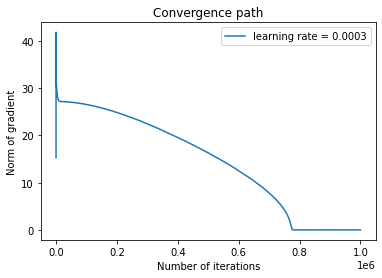

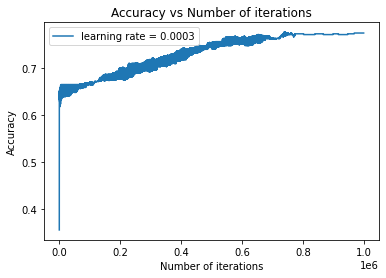

In [ ]:
tria2_5 = LR_convergence(x_train, y_train, 0.0003, 1e6)

----------------------------Learning rate = 0.001----------------------------
terminated after 1000 iterations, with norm of the gradient equal to 66.45228112905755
the weight found: [ 0.18290047  0.05207662 -0.09314978 -0.02014158  0.0265444  -0.00865251
  0.00519138  0.01690451 -0.03550479]


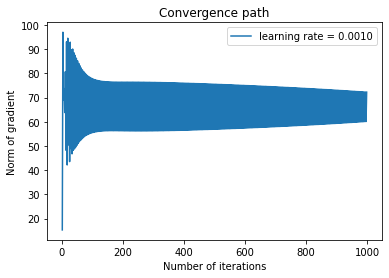

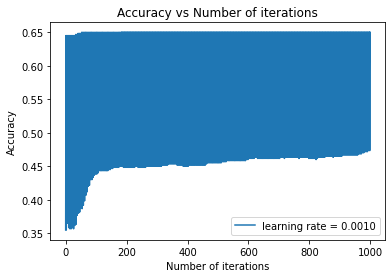

In [ ]:
trial4_1 = LR_convergence(x_train, y_train, 0.001, 1000)

In [ ]:
m_train = model.fit(x_train, y_train)

In [ ]:
pred_train = m_train.predict(x_train)
real_train = y_train
print(accuracy(real_train, pred_train))

In [ ]:
m_val = model.fit(x_val, y_val)

In [ ]:
pred_val = m_val.predict(x_val)
real_val = y_val
print(accuracy(real_val, pred_val))

----------------------------max_iters = 5----------------------------
terminated after 5 iterations, with norm of the gradient equal to 4.523905188434361
the weight found: [ 1.87488333e-05 -1.48449442e-03 -2.68046806e-03 -6.16784331e-04
  9.90779535e-04 -8.40601212e-04 -7.54797848e-06 -7.25575710e-04
 -4.30996274e-05]


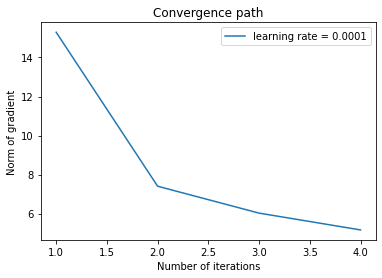

The training accuracy is 0.65
The validation accuracy is 0.63
----------------------------max_iters = 10----------------------------
terminated after 10 iterations, with norm of the gradient equal to 3.1589309371523333
the weight found: [ 1.07606645e-04 -1.15034199e-03 -4.19351211e-03 -9.85765997e-04
  1.61982698e-03 -1.17678005e-03 -8.37942372e-06 -8.91339901e-04
 -7.02278556e-05]


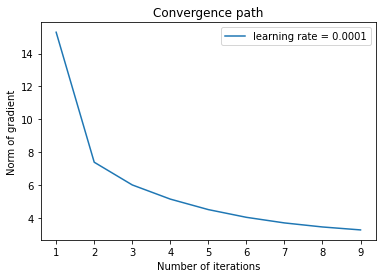

The training accuracy is 0.6533333333333333
The validation accuracy is 0.61
----------------------------max_iters = 50----------------------------
terminated after 50 iterations, with norm of the gradient equal to 1.8635557911922027
the weight found: [ 9.96092187e-04  3.50753798e-03 -1.19751106e-02 -2.94731572e-03
  1.83145214e-03 -2.53100378e-03  1.61881356e-07 -8.89612749e-04
 -2.47392424e-04]


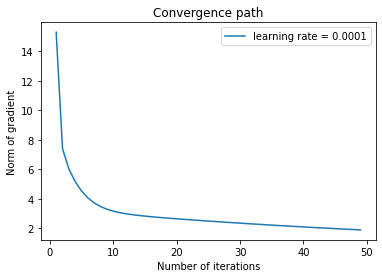

The training accuracy is 0.6633333333333333
The validation accuracy is 0.58
----------------------------max_iters = 100----------------------------
terminated after 100 iterations, with norm of the gradient equal to 1.109344431049708
the weight found: [ 2.15316045e-03  7.10740129e-03 -1.78769502e-02 -4.07440824e-03
  1.74110309e-03 -3.50690342e-03  1.88298218e-05 -5.21136557e-04
 -4.52519698e-04]


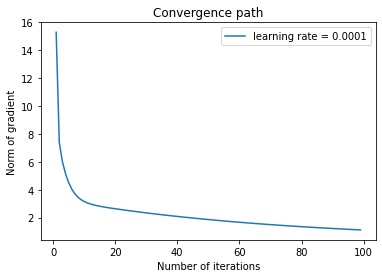

The training accuracy is 0.6683333333333333
The validation accuracy is 0.57
----------------------------max_iters = 1000----------------------------
terminated after 1000 iterations, with norm of the gradient equal to 0.1913251469547686
the weight found: [ 0.02110077  0.01231703 -0.03025843 -0.00153793  0.00145762 -0.00555743
  0.00050871  0.00436253 -0.00378292]


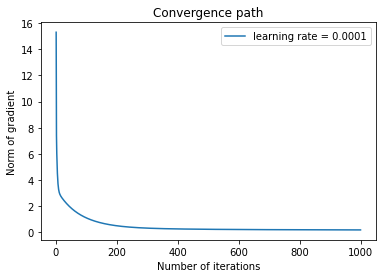

The training accuracy is 0.6783333333333333
The validation accuracy is 0.64
----------------------------max_iters = 10000----------------------------
terminated after 10000 iterations, with norm of the gradient equal to 0.05549797321390253
the weight found: [ 0.10634008  0.01324276 -0.03067612 -0.00097639  0.00155382 -0.00562319
  0.00618771 -0.00815136 -0.03614793]


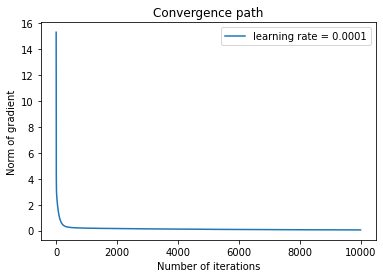

The training accuracy is 0.6983333333333334
The validation accuracy is 0.67
----------------------------max_iters = 100000----------------------------
terminated after 100000 iterations, with norm of the gradient equal to 0.034307864937074266
the weight found: [ 0.13152847  0.014274   -0.02976018 -0.00115303  0.00150239 -0.00238826
  0.06590202 -0.01156154 -0.34707329]


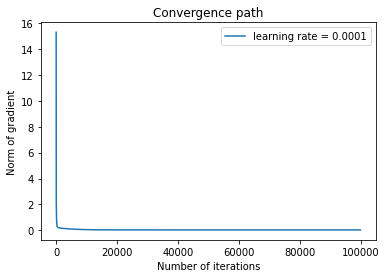

The training accuracy is 0.7083333333333334
The validation accuracy is 0.68


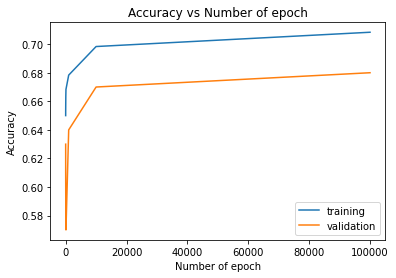

In [ ]:
LR_convergence(x_train, y_train, x_val, y_val, 0.0001, max_iters)

In [ ]:
max_iters = np.linspace(10, 1e5, num=1001)
LR_convergence(x_train, y_train, x_val, y_val, 0.0001, max_iters)

##1.2 Mini-batch stochastic gradient descent

lr = 0.0001 and max_iters = 12130

In [ ]:
def LR_minibatch(x_train, y_train, x_val, y_val, learning_rate, max_iters, minibatch_sizes):
  train_acc = []
  val_acc = []

  for size in minibatch_sizes:
    model = LogisticRegression(add_bias=True, learning_rate=learning_rate, max_iters=max_iters, verbose=False)
    m = model.minibatch_fit(x_train, y_train, size)

    plt.plot(range(m.total_iter), m.cost, label = 'batch size = %d' %size)

    train_acc.append(m.accuracy(x_train, y_train))
    val_acc.append(m.accuracy(x_val, y_val))

  plt.title('Cost vs Number of epoch')
  plt.xlabel('Number of epoch')
  plt.ylabel('Cost')
  plt.legend()
  plt.show()
  

  barWidth = 0.3
  br1 = np.arange(len(minibatch_sizes)) 
  br2 = [x + barWidth for x in br1]
  plt.bar(br1, train_acc, color ='lightsteelblue', width = barWidth,
        edgecolor ='grey', label ='training')
  plt.bar(br2, val_acc, color ='cornflowerblue', width = barWidth,
        edgecolor ='grey', label ='validation')
  plt.xlabel('Size of mini-batch')
  plt.ylabel('Accuracy')
  plt.xticks([r  + barWidth/2 for r in range(len(train_acc))], minibatch_sizes)
  plt.legend()
  plt.show()

  '''
  plt.plot(max_iters, m.cost, label = 'training')

  plt.title('Accuracy vs Mini-batch size')
  plt.xlabel('Size of mini-batch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  '''

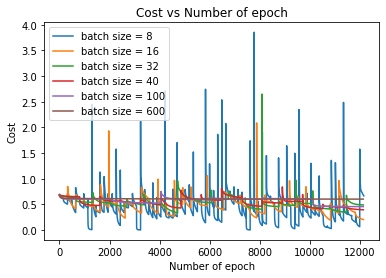

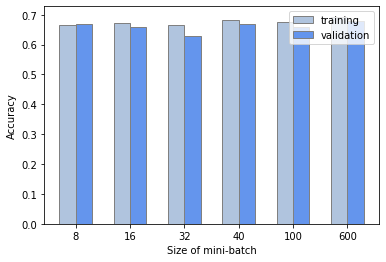

In [ ]:
minibatch_sizes = [8, 16, 32, 40, 100, 600]
LR_minibatch(x_train, y_train, x_val, y_val, 0.0001, 12130, minibatch_sizes)

In [ ]:
#minibatch_sizes = [10, 20, 30, 40, 100, 300, 600]
#LR_minibatch(x_train, y_train, x_val, y_val, 0.0001, 12130, minibatch_sizes)

terminated all 1 mini-batch(es), with norm of the gradient equal to 0.046892110973128676
the weight found: [ 0.11382825  0.01335848 -0.03070646 -0.00097644  0.00156298 -0.00551013
  0.00764175 -0.00936151 -0.0437136 ]


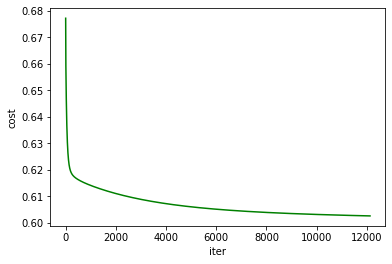

In [ ]:
model = LogisticRegression(learning_rate=0.0001, max_iters=12130, verbose=True, )
m = model.minibatch_fit(x_train,y_train,600)

iter = range(m.total_iter)
cost = m.cost
plt.plot(iter, cost, 'g')
plt.xlabel('iter')
plt.ylabel('cost')
#plt.legend()
plt.show()

##1.3 Momentum





### visualizing accuracy applying momentum

In [ ]:
def momentum_convergence(x_train, y_train, x_val, y_val, learning_rate, max_iters, beta):
    #train_acc = []
    m_val_acc = []
    val_acc = []
    iters = []

    model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=max_iters, verbose=False)
    with_momentum = model.gd_momentum(x_train, y_train, beta)
    without_momentum = model.fit(x_train, y_train)
    #weight = m.w
    #print(m.accuracy(x_train,y_train))
    #train_acc.append(m.accuracy(x_train,y_train))
    m_val_acc.append(with_momentum.accuracy(x_val,y_val))
    val_acc.append(without_momentum.accuracy(x_val,y_val))
    iters.append()
  
    plt.plot(max_iters, train_acc, label = 'training')
    plt.plot(max_iters, val_acc, label = 'validation')
    #plt.plot(max_iters, weight, label = 'weight')
    plt.title('Accuracy vs Number of epoch (with momentum)')
    plt.xlabel('Number of epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def momentum_convergence(x_train, y_train, x_val, y_val, learning_rate, max_iters, beta, batch_size=600):
    model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=max_iters, verbose=False)
    without_momentum = model.fit(x_train, y_train)
    val_acc = without_momentum.acc
    iter = without_momentum.iter

    if batch_size<600:
      with_momentum = model.minibatch_momentum(x_train, y_train, beta, batch_size)
      val_acc_momentum = with_momentum.iter

In [ ]:
'''
def m_accuracy(x,y,learning_rate,max_iters,beta):
  model1 = LogisticRegression(learning_rate=learning_rate, max_iters=max_iters, verbose=True)
  m1 = model1.fit(x,y)
  model2 = LogisticRegression(learning_rate=learning_rate, max_iters=max_iters, verbose=True)
  m2 = model2.gd_momentum(x,y,beta)
  #m = model.fit(x,y)
  real = y
  pred1 = m1.predict_outcome(x)
  pred2 = m2.predict_outcome(x)
  acc1 = accuracy(real,pred1)
  acc2 = accuracy(real,pred2)
  return acc1, acc2
'''

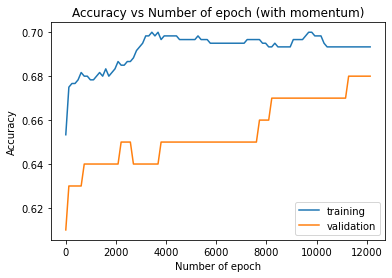

In [ ]:
max_iters = np.linspace(10,12130,num=100)
m_trial = m_convergence(x_train,y_train,x_val,y_val,0.0001,max_iters,.2)

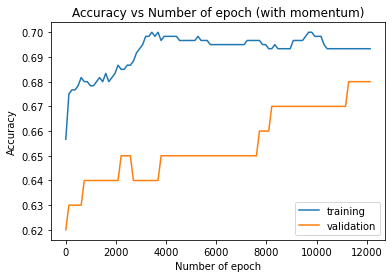

In [ ]:
max_iters = np.linspace(10,12130,num=100)
m_trial = m_convergence(x_train,y_train,x_val,y_val,0.0001,max_iters,.6)

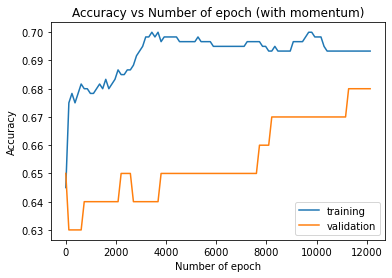

In [ ]:
max_iters = np.linspace(10,12130,num=100)
m_trial = m_convergence(x_train,y_train,x_val,y_val,0.0001,max_iters,.9)

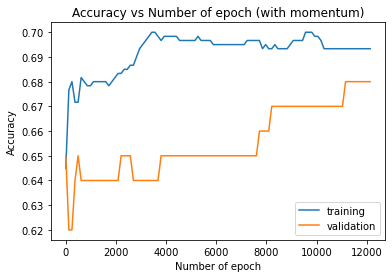

In [ ]:
max_iters = np.linspace(10,12130,num=100)
m_trial = m_convergence(x_train,y_train,x_val,y_val,0.0001,max_iters,.99)

### visualizing accuracy applying momentum; minibatches

In [ ]:
def m_mini_convergence(x_train,y_train,x_val,y_val,learning_rate,max_iters,beta,minibatch_sizes):
    train_acc = []
    val_acc = []
    for size in minibatch_sizes:
        model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=max_iters, verbose=False)
        m = model.minibatch_momentum(x_train,y_train,beta,size)
        plt.plot(range(m.iter), m.cost, label = 'batch size = %d' %size)
        train_acc.append(m.accuracy(x_train,y_train))
        val_acc.append(m.accuracy(x_val,y_val))
    
    print(f'model weight: {m.w}')
    
    plt.title(f'Cost vs Number of epoch with momentum = {beta}')
    plt.xlabel('Number of epoch')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()
    
    barWidth = 0.3
    br1 = np.arange(len(minibatch_sizes)) 
    br2 = [x + barWidth for x in br1]
    plt.bar(br1, train_acc, color ='lightsteelblue', width = barWidth,
    edgecolor ='grey', label ='training')
    plt.bar(br2, val_acc, color ='cornflowerblue', width = barWidth,
    edgecolor ='grey', label ='validation')
    plt.xlabel('Size of mini-batch')
    plt.ylabel('Accuracy')
    plt.xticks([r  + barWidth/2 for r in range(len(train_acc))], minibatch_sizes)
    plt.legend()
    plt.show()   

model weight: [ 0.11731803  0.01343842 -0.03080095 -0.00100499  0.00157127 -0.00555134
  0.00692968 -0.00995478 -0.04013078]


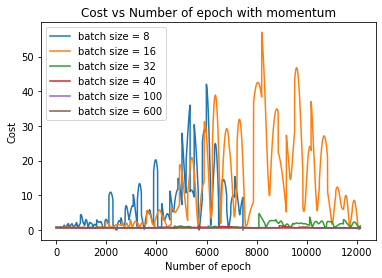

max training accuracy = 0.6933333333333334
max validation accuracy = 0.68


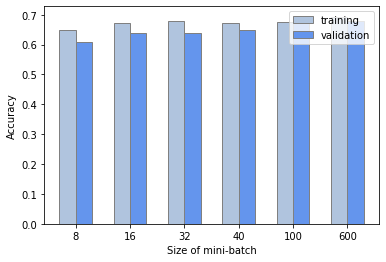

In [ ]:
minibatch_sizes = [8, 16, 32, 40, 100, 600]
mini_trial1 = m_mini_convergence(x_train,y_train,x_val,y_val,0.0001,12130,.999,minibatch_sizes)

model weight: [ 0.11385458  0.01335876 -0.0307068  -0.0009764   0.00156303 -0.00551032
  0.00763537 -0.00936589 -0.04368158]


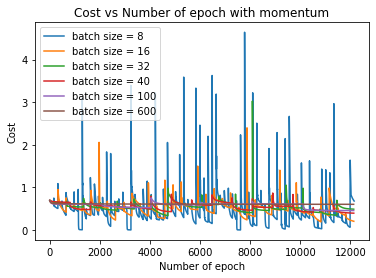

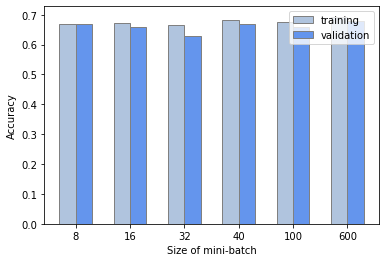

In [ ]:
# learning_rate = .0001, beta = .9, max_iters = 12130
minibatch_sizes = [8, 16, 32, 40, 100, 600]
mini_trial0 = m_mini_convergence(x_train,y_train,x_val,y_val,0.0001,12130,.9,minibatch_sizes)

model weight: [ 0.13201386  0.01398188 -0.03025194 -0.00106868  0.00154178 -0.00372598
  0.04080389 -0.01195679 -0.21291608]


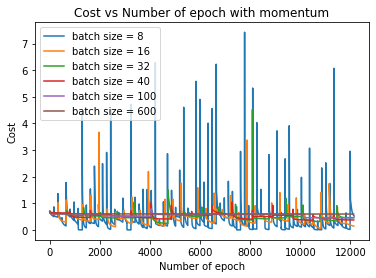

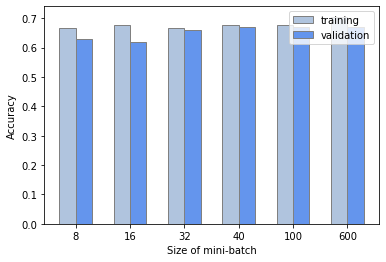

In [ ]:
minibatch_sizes = [8, 16, 32, 40, 100, 600]
mini_trial2 = m_mini_convergence(x_train,y_train,x_val,y_val,0.0005,12130,.6,minibatch_sizes)

model weight: [ 0.1138302   0.0133585  -0.03070648 -0.00097644  0.00156298 -0.00551015
  0.00764127 -0.00936183 -0.04371124]


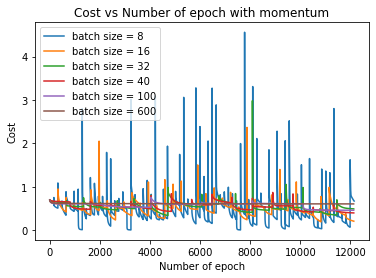

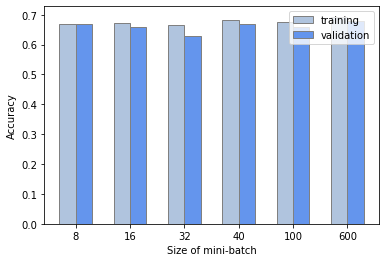

In [ ]:
minibatch_sizes = [8, 16, 32, 40, 100, 600]
mini_trial3 = m_mini_convergence(x_train,y_train,x_val,y_val,0.0001,12130,.4,minibatch_sizes)

### comparing weights between normal lr and lr w/ momentum

In [ ]:
def plot_weight(x_train,y_train,x_val,y_val,learning_rate,max_iters,beta):
    for it in max_iters:
        m1 = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=it, verbose=False)
        m2 = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=it, verbose=False)
        m1.fit(x_train,y_train)
        m2.gd_momentum(x_train,y_train,beta)
    w1 = m1.w
    w2 = m2.w
    print(f'w1: {w1}')
    print(f'w2: {w2}')
    plt.plot(range(len(w1)),w1,label='weight')
    plt.plot(range(len(w2)),w2,label='weight with momentum')
    plt.title("Weight vs weight w/ momentum")
    plt.legend()
    plt.show()

### visualizing cost applying momentum; minibatches

In [ ]:
def plot_cost(x,ylearning_rate,max_iters,beta):
  for it in max_iters:
    m1 = LogisticRegression()
    m2 = LogisticRegression()
    m1.fit(x,y)
    m2.gd_momentum(x,y,beta)
  cost1 = m1.cost
  cost2 = m2.cost
  plt.plot(cost1,label='cost')
  plt.plot(cost2,label='cost w/ momentum')
  plt.title('Cost vs cost w/ momentum')
  plt.legend()
  plt.show()

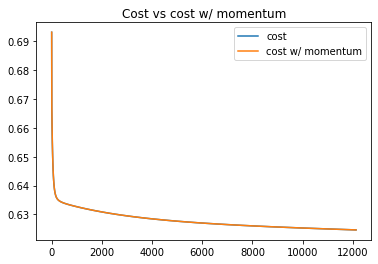

In [ ]:
max_iters = np.linspace(10, 12130, num=100)
plot_cost(x_val,y_val,.0001,max_iters,.6)

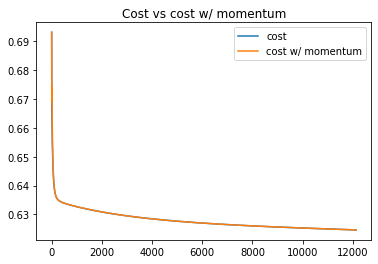

In [ ]:
max_iters = np.linspace(10, 12130, num=100)
plot_cost(x_val,y_val,.0001,max_iters,.9)

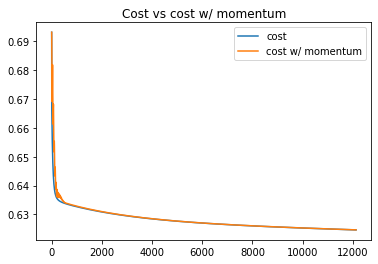

In [ ]:
max_iters = np.linspace(10, 12130, num=100)
plot_cost(x_val,y_val,.0001,max_iters,.99)

### visualization of accuracy with and without momentum

In [ ]:
def plot_accuracy(x_train,y_train, x_val, y_val, learning_rate,max_iters,beta):
  val_acc = []
  val_acc_m = []
  for it in np.linspace(1, max_iters, 10):
      m = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=it, verbose=False)
      m1 = m.fit(x_train,y_train)
      m2 = m.gd_momentum(x_train,y_train,beta)
      val_acc.append(m1.accuracy(x_val,y_val))
      val_acc_m.append(m2.accuracy(x_val,y_val))
  plt.plot(np.linspace(1, max_iters, 10), val_acc,label='without momentum')
  plt.plot(np.linspace(1, max_iters, 10), val_acc_m,label='with momentum')
  plt.xlabel("Number of epochs")
  plt.ylabel("Validation accuracy")
  plt.title("Validation accuracy vs number of epochs")
  plt.legend()
  plt.show()

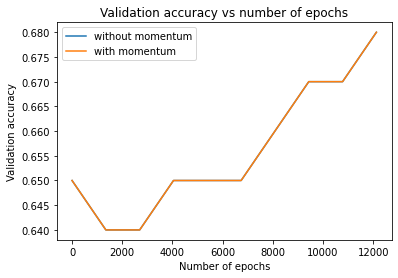

In [ ]:
plot_accuracy(x_train,y_train, x_val, y_val, 0.0001,12130,0.9)

##1.4 Repeat the previous step for the smallest/largest batch size

In [ ]:
def m_batchsize(x,y,learning_rate,max_iters,beta,batch):
  model1 = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=max_iters, verbose=False)
  m1 = model1.minibatch_fit(x,y,batch)
  model2 = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-4, max_iters=max_iters, verbose=False)
  m2 = model2.minibatch_momentum(x,y,beta,batch)
  plt.plot(m1.cost, label = 'batch size = %d' %batch)
  plt.plot(m2.cost, label = f'batch size = {batch}, momentum = {beta}')
  plt.xlabel('Epoch')
  plt.ylabel('Cost')
  plt.title(f'Cost vs batch size with learning rate = {learning_rate}')
  plt.legend()
  plt.show()


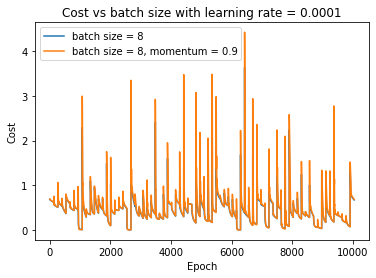

In [ ]:
m_batchsize(x_train,y_train,0.0001,10000,.9,8)

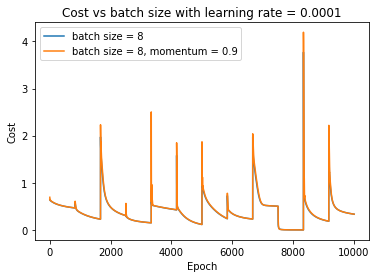

In [ ]:
m_batchsize(x_val,y_val,learning_rate=0.0001,max_iters=10000,beta=.9,batch=8)

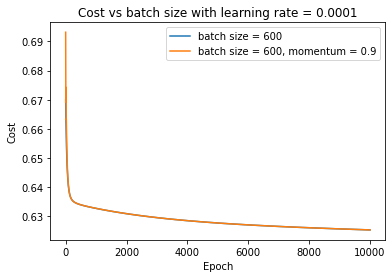

In [ ]:
m_batchsize(x_val,y_val,learning_rate=0.0001,max_iters=10000,beta=.9,batch=600)

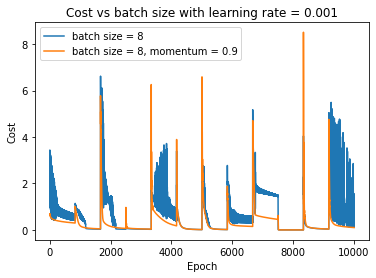

In [ ]:
m_batchsize(x_val,y_val,learning_rate=0.001,max_iters=10000,beta=.9,batch=8)

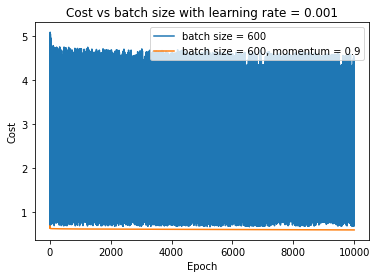

In [ ]:
m_batchsize(x_val,y_val,learning_rate=0.001,max_iters=10000,beta=.9,batch=600)

#Part 2. Text Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import string
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
df2 = pd.read_csv('/content/fake_news_train.csv')
df2.head(20)

,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
5,Posted\nAn empty classroom in rural communitie...,0
6,The whales we know today look nothing like the...,1
7,Local news anchor Richard Ray announced Thursd...,1
8,PROVO — In the 17 years that he’s been married...,1
9,"Before a crowd of 4,000 people, Sen. Cory Book...",1


In [ ]:
len(df2)

20000

In [ ]:
temp = []
for i in range(0, len(df2)-1):
    j = i+1
    if str(df2.iloc[i]['text']) == str(df2.iloc[j]['text']):
        temp.append(i)
for i in temp:
    df2y=df2.drop(labels=[i], axis=0)

df2.reset_index(drop=True,inplace = True) 

In [ ]:
len(df2)

20000

In [ ]:
df2.replace("", np.nan, inplace=True)
df2.dropna(axis='rows',inplace=True)

In [ ]:
len(df2)

20000

Get the number of sentences and the number of unique words: 

In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [ ]:
sent_count,word_count= get_sentence_word_count(df2['text'].tolist())
print("Number of sentences in text column: "+ str(sent_count))
print("Number of unique words in text column: "+str(word_count))

Number of sentences in text column: 459566
Number of unique words in text column: 209601


Remove the numbers and punctations except "." and "," in the text: 

In [ ]:
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

In [ ]:
def remove_punct(text):
    punctuations = '@#!?+&*[]-%:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, "")

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

Remove not printable words: 

In [ ]:
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

Remove all URLs and HTMLs

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

[link text](https://)Remove @ and mention: 

In [ ]:
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'',text)

In [ ]:
def remove_whitespace(text):
  text = text.replace("  ", " ")
  return text

In [ ]:
def clean_data(text):
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_punct(text)
    text = remove_number(text)
    text = remove_whitespace(text)
    text = remove_not_ASCII(text)
    text = text.lower()
    text = remove_whitespace(text)
    return text

In [ ]:
df2['text'] = df2['text'].apply(lambda x : clean_data(x))

In [ ]:
df2.head(30)

,text,label
0,indian fruit is so important to so many people...,0
1,"fort worth, texas ur inc. will hold a conferen...",0
2,"with three of the four new carriers, the niger...",0
3,lets start with the classic annual dividend re...,0
4,following are some of the major events to have...,1
5,posted\nan empty classroom in rural communitie...,0
6,the whales we know today look nothing like the...,1
7,local news anchor richard ray announced thursd...,1
8,"provo in the years that hes been married, utah...",1
9,"before a crowd of people, sen. cory booker dnj...",1


In [ ]:
for i in range(0, len(df2)-1):
  if ' x ' in df2["text"][i]:
    print(df2["text"][i])

In [ ]:
def remove_abbreviation(text):
    text = text.replace("let ' s ", " let us ")
    text = text.replace("\n", " ")
    text = text.replace("x ", " ")
    text = text.replace(" inc ", " incorporated ")
    text = text.replace(" he’s ", " he has ")
    text = text.replace(" she’s ", " she has ")
    text = text.replace(" it’s ", " it has ")
    return text

In [ ]:
for i in range(0, len(df2)-1):
  if " hello " in df2["text"][i]:
    print(df2["text"][i])

los angeles yasiel puig was late arriving to dodger stadium monday in his first game since being traded to cincinnati.
he turned up with a bang once the game began.
puig hammered a tworun homer in the first inning off clayton kershaw, who was making his season debut for the dodgers.
puig was greeted with a mix of boos and cheers as he rounded the bases to put the reds ahead 
the dodgers honoured puig, matt kemp, alex wood and kyle farmer in a pregame video that highlighted their time in la. puig, kemp and farmer doffed their caps in appreciation. wood just rejoined the reds after being injured.
puig, from cuba, awed fans with his cannon of an arm and infuriated management with his inconsistent efforts on the field during his six years with the dodgers.
he missed receiving his national league championship series ring in person from dodgers owner mark walter and other frontoffice personnel.
they presented the jewelry to kemp, wood and farmer during an informal gathering outside the visit

In [ ]:
df2['text'] = df2['text'].apply(remove_abbreviation)

In [ ]:
additionl_wordlist = ("")

In [ ]:
df2.head(40)

In [ ]:
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [ ]:
df2['text'] = df2['text'].apply(lemmatize_text)

In [ ]:
len(df2['text'][1])

497

In [ ]:
df2['text'][1]

'fort worth , texas ur inc. will hold a conference call today thursday , may at a.m. central time p.m. eastern time to discus it result for the first quarter of fiscal and the annual meeting of shareholder held on may at the century plaza harris ranch near fort worth , texas . when prompted , investor will hear this call by confirming the passcode management will also refer to it annual meeting of shareholder on may which will be held at the century plaza harris ranch near fort worth , texas .'

In [ ]:
df2.head(30)

,text,label
0,indian fruit is so important to so many people...,0
1,"fort worth , texas — urú inc . when prompted ,...",0
2,"with three of the four new carrier , the niger...",0
3,let us start with the classic annual dividend...,0
4,following are some of the major event to have ...,1
5,posted an empty classroom in rural community n...,0
6,the whale we know today look nothing like they...,1
7,local news anchor richard ray announced thursd...,1
8,"provo — in the year that he ’ s been married ,...",1
9,"before a crowd of people , sen . we ’ re not b...",1


In [ ]:
 stop_words = list(stopwords.words('english'))

In [ ]:
def remove_stopwords(text):
    return [txt for txt in text if txt not in list(stop_words)] 

In [ ]:
# df2['text'] = remove_stopwords(df2['text'])

In [ ]:
count = CountVectorizer() #max_features, ngram_range
X_train = df2['text']
y_train = df2['label']
X = count.fit_transform(X_train.values)



In [ ]:
X.shape

In [ ]:
count.get_feature_names()

In [ ]:
news_test = pd.read_csv("/content/news_test.csv")
news_test['text'] = news_test['text'].apply(clean_data)
news_test['text'] = news_test['text'].apply(remove_abbreviation)
news_test['text'] = remove_stopwords(news_test['text'])
X_test, y_test = news_test['text'], news_test['label']


In [ ]:
pipe = Pipeline([('vectorizer',count),('classifier',LogisticRegression())])
model = pipe.fit(X_train,y_train)
# accuracy: 
# pred = model.predict(X_test)
# accuracy = accuracy_score(pred,y_test)
# print(f'accuracy using logistic regression: {accuracy:.2f}')
# lr_matrix = confusion_matrix(y_test,pred)

In [ ]:
def remove_prefixes(text):
  text = text.replace(r'http\S', '', regex=True).replace(r'www\S', '', regex=True)
  return text

In [ ]:
def expand_contractions(text):
  # use custom dict or import lib

In [ ]:
from nltk.stem import WordNetLemmatizer
def lemma(text):
  lem = WordNetLemmatizer()
  tokens = tokens.apply(lambda x: [lem.lemmatize(word) for word in x])
  return tokens
  # depends on if we called whatever tokenize function before doing lemma
  # for i in range(len(tokens)):
  #   tokens[i] = ' '.join(tokens[i])
  # return tokens